<a href="https://colab.research.google.com/github/MehwishSayyed/Week3--Household-Energy-Consumption-Forecasting-System/blob/main/IntershipAssigments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo




In [3]:
from ucimlrepo import fetch_ucirepo

dataset = fetch_ucirepo(id=235)

# Original data
df = dataset.data.original
df.isnull().sum()


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,25979


In [4]:
# =============================
# 1. IMPORT LIBRARIES
# =============================
import pandas as pd
import numpy as np
from scipy import stats
from ucimlrepo import fetch_ucirepo   # to fetch the dataset directly

# =============================
# 2. LOAD DATASET
# =============================
# Fetch the "Individual household electric power consumption" dataset (ID 235)
dataset = fetch_ucirepo(id=235)

# Original data
df = dataset.data.original

# =============================
# 3. INITIAL INSPECTION
# =============================
print("Original dataset shape:", df.shape)
print("Columns available:", df.columns.tolist())
print(df.head())

# =============================
# 4. CLEANING PROCESS
# =============================

# Combine 'Date' and 'Time' columns into one datetime column
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# Drop the original Date and Time columns
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Set datetime as index
df.set_index('datetime', inplace=True)

# Replace '?' with NaN (since dataset uses '?' for missing values)
df.replace('?', np.nan, inplace=True)

# Convert all remaining columns to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# =============================
# 5. HANDLE MISSING VALUES
# =============================
# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any remaining missing values (forward and backward)
df = df.ffill().bfill()

print("Total missing values after cleaning:", df.isnull().sum().sum())

# =============================
# 6. REMOVE OUTLIERS (OPTIONAL)
# =============================
# Remove rows with z-score > 3
z_scores = np.abs(stats.zscore(df))
df = df[(z_scores < 3).all(axis=1)]

# =============================
# 7. FINAL CHECK
# =============================
print("Cleaned dataset shape:", df.shape)
print(df.info())
print(df.head())


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


Original dataset shape: (2075259, 9)
Columns available: ['Date', 'Time', 'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000         

/tmp/ipython-input-3095581341.py:30: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


Total missing values after cleaning: 0
Cleaned dataset shape: (1938923, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1938923 entries, 2006-12-16 17:38:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 118.3 MB
None
                     Global_active_power  Global_reactive_power  Voltage  \
datetime                                                                   
2006-12-16 17:38:00                4.054                  0.422   235.24   
2006-12-16 17:39:00                3.384                  0.282   237.14   
2006-12-16 17:40:00                3.270                  0.152   236.73   
2006-12-16 17:41:00          

In [5]:
# =============================
# 8. FEATURE ENGINEERING
# =============================

# Extract time-based features
df['hour'] = df.index.hour
df['weekday'] = df.index.dayofweek
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# Rolling averages (3, 6, 12 intervals)
df['rolling_3'] = df['Global_active_power'].rolling(3).mean()
df['rolling_6'] = df['Global_active_power'].rolling(6).mean()
df['rolling_12'] = df['Global_active_power'].rolling(12).mean()

# Lag features (previous hour & previous day)
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_24'] = df['Global_active_power'].shift(24)

# Drop rows with NaN created by rolling/lag
df = df.dropna()

print("Dataset shape after feature engineering:", df.shape)
df.head()


Dataset shape after feature engineering: (1938899, 15)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,weekday,is_weekend,rolling_3,rolling_6,rolling_12,lag_1,lag_24
datetime,,,,,,,,,,,,,,,
2006-12-16 18:20:00,2.928,0.0,235.25,12.4,0.0,1.0,17.0,18,5,1,3.327333,2.961333,3.018667,2.852,4.054
2006-12-16 18:21:00,2.940,0.0,236.04,12.4,0.0,2.0,17.0,18,5,1,2.906667,2.936333,2.925500,2.928,3.384
2006-12-16 18:22:00,2.934,0.0,235.51,12.4,0.0,1.0,17.0,18,5,1,2.934000,3.040667,2.964000,2.940,3.270
2006-12-16 18:23:00,2.926,0.0,235.68,12.4,0.0,1.0,17.0,18,5,1,2.933333,3.130333,2.975333,2.934,3.430
2006-12-16 18:24:00,3.452,0.0,235.20,15.2,0.0,1.0,17.0,18,5,1,3.104000,3.005333,3.044333,2.926,3.266


In [6]:
from google.colab import files

# Save the cleaned dataset as a compressed .gz file
df.to_csv("cleaned_household_power_consumption.csv.gz", index=False, compression='gzip')

# Optional: check file size before download
import os
print("Compressed file size:", round(os.path.getsize("cleaned_household_power_consumption.csv.gz") / (1024*1024), 2), "MB")

# Download the compressed file
# files.download("cleaned_household_power_consumption.csv.gz")


Compressed file size: 39.16 MB


In [7]:
# Convert index to datetime (if not already)
df.index = pd.to_datetime(df.index)

# Sort by datetime index
df = df.sort_index()

print(df.index[:5])   # preview


DatetimeIndex(['2006-12-16 18:20:00', '2006-12-16 18:21:00',
               '2006-12-16 18:22:00', '2006-12-16 18:23:00',
               '2006-12-16 18:24:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)


week 2


global active column will be my output

In [12]:
# Define features and target

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x = df.drop(columns=['Global_active_power'])
y = df['Global_active_power']


#spliting the data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# 80 % for training
# 20 % for testing

# create train model

model = RandomForestRegressor(
    n_estimators=30,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

model.fit(x_train, y_train)

#prediction

y_pred = model.predict(x_test)

# Evaluate performance

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Absolute Error: 0.011581374799633256
Mean Squared Error: 0.0005324382472675082
R² Score: 0.9991411906591893


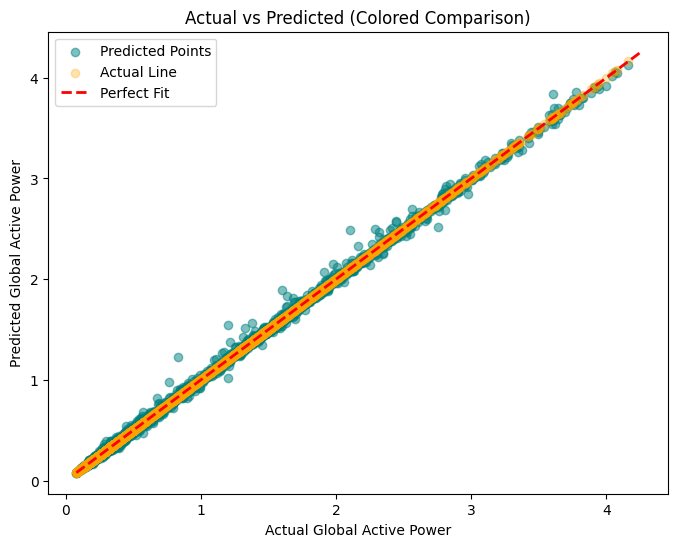

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Actual vs Predicted points (different colors)
plt.scatter(y_test[:5000], y_pred[:5000], color='teal', alpha=0.5, label='Predicted Points')
plt.scatter(y_test[:5000], y_test[:5000], color='orange', alpha=0.3, label='Actual Line')

# Perfect prediction diagonal
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')

plt.xlabel("Actual Global Active Power")
plt.ylabel("Predicted Global Active Power")
plt.title("Actual vs Predicted (Colored Comparison)")
plt.legend()
plt.show()


In [14]:
# numeric accuracy
# Calculate percentage accuracy
accuracy = 100 * (1 - (abs(y_test - y_pred) / y_test).mean())
print(f"Average Prediction Accuracy: {accuracy:.2f}%")


Average Prediction Accuracy: 98.32%


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
accuracy = 100 - mape

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Average Prediction Accuracy: {accuracy:.2f}%")


Mean Absolute Percentage Error (MAPE): 1.68%
Average Prediction Accuracy: 98.32%


In [16]:
comparison = pd.DataFrame({
    'Actual': y_test.values,
    'Prediction': y_pred
})

# Drop rows with very small or zero actual values
comparison = comparison[comparison['Actual'] > 0.1]

# Calculate per-row accuracy safely
comparison['Accuracy (%)'] = 100 * (1 - abs(comparison['Actual'] - comparison['Prediction']) / comparison['Actual'])
comparison['Accuracy (%)'] = comparison['Accuracy (%)'].clip(lower=0, upper=100)  # avoid negative or over 100%

print(comparison.head(10))
print(f"\nAverage Accuracy: {comparison['Accuracy (%)'].mean():.2f}%")
print(f"Minimum Accuracy: {comparison['Accuracy (%)'].min():.2f}%")
print(f"Maximum Accuracy: {comparison['Accuracy (%)'].max():.2f}%")


   Actual  Prediction  Accuracy (%)
0   3.112    3.114766     99.911133
1   1.484    1.493300     99.373310
2   0.438    0.426419     97.355974
3   0.152    0.151558     99.709222
4   0.256    0.255034     99.622561
5   2.350    2.260381     96.186431
6   0.268    0.269391     99.480985
7   2.264    2.351337     96.142358
8   0.286    0.305155     93.302598
9   1.492    1.484904     99.524391

Average Accuracy: 98.31%
Minimum Accuracy: 0.00%
Maximum Accuracy: 100.00%


In [17]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Global_active_power'])
y = df['Global_active_power']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [23]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=10,
    min_samples_split=10,
    n_jobs=2,
    random_state=42
)

rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)


In [19]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(x_train, y_train)
y_pred_xgb = xgb_model.predict(x_test)


In [24]:
from sklearn.metrics import *
from sklearn.metrics import mean_absolute_percentage_error

# Random Forest
print("RF MAPE:", mean_absolute_percentage_error(y_test, y_pred_rf)*100)
print("RF MAE:", mean_absolute_error(y_test, y_pred_rf))
print("RF R2:", r2_score(y_test, y_pred_rf))

# XGBoost
print("XGB MAPE:", mean_absolute_percentage_error(y_test, y_pred_xgb)*100)
print("XGB MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("XGB R2:", r2_score(y_test, y_pred_xgb))


RF MAPE: 2.131187918541624
RF MAE: 0.013958702949745985
RF R2: 0.9985227257837044
XGB MAPE: 2.3156249045456465
XGB MAE: 0.013611867387662138
XGB R2: 0.998927603324032


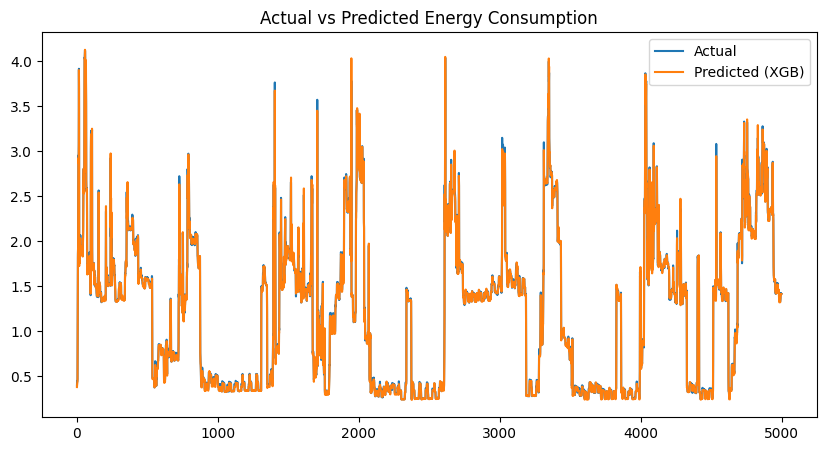

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values[:5000], label="Actual")
plt.plot(y_pred_xgb[:5000], label="Predicted (XGB)")
plt.legend()
plt.title("Actual vs Predicted Energy Consumption")
plt.show()


In [27]:
!pip install streamlit pyngrok
import pickle
pickle.dump(xgb_model, open("xgb_model.pkl", "wb"))



In [55]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb

st.title("⚡ XGBoost Energy Consumption Predictor")
st.write("Predict **Global Active Power** using your trained XGBoost model.")

# --------------------------------------
# Load trained XGBoost model
# --------------------------------------
model_xgb = pickle.load(open("xgb_model.pkl", "rb"))

# --------------------------------------
# Load sample feature file (for slider ranges)
# --------------------------------------
df_sample = pd.read_csv("sample_features.csv")   # Only feature columns

st.sidebar.header("Input Features")
inputs = []

# Generate input boxes dynamically
for col in df_sample.columns:
    col_min = float(df_sample[col].min())
    col_max = float(df_sample[col].max())
    col_mean = float(df_sample[col].mean())

    value = st.sidebar.number_input(
        f"{col}",
        min_value=col_min,
        max_value=col_max,
        value=col_mean
    )
    inputs.append(value)

# Convert to numpy array
input_array = np.array([inputs])

# --------------------------------------
# Prediction Section
# --------------------------------------
if st.button("Predict Energy Usage"):
    prediction = model_xgb.predict(input_array)[0]
    st.success(f"🔋 Predicted Global Active Power: **{prediction:.5f} kW**")

# --------------------------------------
# Feature Importance Section
# --------------------------------------
st.write("---")
st.header("📊 Feature Importance (XGBoost)")

fig, ax = plt.subplots(figsize=(8, 5))
xgb.plot_importance(model_xgb, ax=ax)
st.pyplot(fig)


Overwriting app.py


In [57]:
df.drop(columns=['Global_active_power']).to_csv("sample_features.csv", index=False)


In [58]:
!kill -9 $(ps aux | grep streamlit | awk '{print $2}') 2>/dev/null
!kill -9 $(ps aux | grep ngrok | awk '{print $2}') 2>/dev/null
!kill -9 $(lsof -t -i:8501) 2>/dev/null
!pkill -f ngrok
!pkill -f streamlit
!ps aux | grep -i "ngrok\|streamlit"



^C
^C
root       19574  0.0  0.0   7376  3592 ?        S    10:20   0:00 /bin/bash -c ps aux | grep -i "ngrok\|streamlit"
root       19576  0.0  0.0   6616  2516 ?        S    10:20   0:00 grep -i ngrok\|streamlit


In [59]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!apt install ./cloudflared-linux-amd64.deb


--2025-11-17 10:20:20--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb [following]
--2025-11-17 10:20:20--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/8a32f7c6-649c-4f0d-806d-e14c19d0786d?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-17T11%3A05%3A45Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4d

In [67]:
!streamlit run app.py --server.port 8700 &>/content/logs.txt &


In [ ]:
!cloudflared tunnel --url http://localhost:8700 --no-autoupdate


2025-11-17T10:22:51Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-11-17T10:22:51Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-11-17T10:22:55Z INF +--------------------------------------------------------------------------------------------+
2025-11-17T10:22:55Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-11-17T10:22:55Z INF |  https://impossible-gtk-directors-heroes.trycloudflare